# ヘイトスピーチ検出 ベースラインチュートリアル
このNotebookはNishikaコンペティション `ヘイトスピーチ検出`のチュートリアルです。  

BERTの事前学習済みモデルに`cl-tohoku/bert-base-japanese-whole-word-masking`を使用して、簡単なベースラインを作成します。

ディレクトリの構造は以下のようになっています

```
/
├ notebook
│   └ tutotial.ipynb
└ input
   └ hate-speech-detection
      ├ train.csv
      ├ test.csv
      └ sample_submission.csv
```



In [1]:
# ドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 自身のColab環境によってディレクトリを変更して下さい
import os
os.chdir("/content/drive/MyDrive/ColabNotebooks/nishika/hate_speech")

In [3]:
!nvidia-smi

Wed Oct 19 01:03:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# 必要なライブラリのインストール
!pip install -q ginza ja_ginza datasets transformers[ja]
!pip install neologdn
!pip install mojimoji

     |████████████████████████████████| 59.1 MB 1.2 MB/s 
     |████████████████████████████████| 441 kB 67.9 MB/s 
     |████████████████████████████████| 5.3 MB 52.9 MB/s 
     |████████████████████████████████| 2.2 MB 50.8 MB/s 
     |████████████████████████████████| 163 kB 70.5 MB/s 
     |████████████████████████████████| 212 kB 69.9 MB/s 
     |████████████████████████████████| 115 kB 68.3 MB/s 
     |████████████████████████████████| 127 kB 47.7 MB/s 
     |████████████████████████████████| 7.6 MB 52.2 MB/s 
     |████████████████████████████████| 583 kB 67.4 MB/s 
     |████████████████████████████████| 47.4 MB 1.6 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 13.4 MB 49.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 6.6 MB/s 
  Created wheel for neologdn: filename=neologdn-0.5.1-cp37-cp37m-linux_x86_64.whl size=17296

In [5]:
import os
import random
from dataclasses import dataclass
from pathlib import Path
from collections import Counter
import neologdn
import spacy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import mojimoji

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import (
    AutoModel, AutoTokenizer, EvalPrediction, Trainer, 
    TrainingArguments, AutoModelForSequenceClassification,
)
import datasets
from datasets import Dataset

COMPETION_DATA_DIR = Path("/content/drive/MyDrive/input/nishika/hate_speech")

In [6]:
def seed_everything(seed: int):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED)

In [7]:
print(f"torch version: {torch.__version__}")
print(f"transfomers version: {transformers.__version__}")
print(f"datasets version: {datasets.__version__}")

torch version: 1.12.1+cu113
transfomers version: 4.23.1
datasets version: 2.6.1


# データの読み込み

In [8]:
train_df = pd.read_csv(COMPETION_DATA_DIR/"train.csv")
test_df = pd.read_csv(COMPETION_DATA_DIR/"test.csv")
sub_df = pd.read_csv(COMPETION_DATA_DIR/"sample_submission.csv")

In [9]:
train_1_df = train_df[train_df['label'] == 1]
train_0_df = train_df[train_df['label'] == 0].sample(frac=0.9, random_state = 42)
train_df = pd.concat([train_1_df, train_0_df], axis = 0)

# EDA
最初にカラム情報、ラベル数、文字数などを確認します


In [10]:
print("train")
display(train_df)

print("test")
display(test_df)

print("sample submission")
display(sub_df)

train


,id,source,text,label
2,c535f5613,livejupiter,日本人として生まれても無能な低学歴って分かったら日本人の権利剥奪して追放すべきやろ\n甘えるな,1
34,69d0d4458,livejupiter,そら女には力はないし頭も男の方が優れてるからな\n女には女の仕事があって、男には男の仕事があ...,1
46,252ac74ca,newsplus,北朝鮮による日本人拉致と平行して、在日朝鮮人の拉致も行われている。\n日本から在日朝鮮人を拉...,1
57,604fad2a9,news4vip,独身女なんて人間としての価値無いからな\n女の仕事は、養鶏場の鶏と同じで、産むのが仕事\nそ...,1
94,4b6452c69,livejupiter,日本人じゃないしいいよ別に\n偽善大国日本なんて滅んだらいい,1
...,...,...,...,...
1780,2b23f0c32,news4vip,まぁ、正直脚本だけで見たらもっと面白いものはあるのは分かる。\n小説とか漫画とか諸々込みで。...,0
530,04a481acb,newsplus,何年か前に独裁者女体化本ってのがあって、その時に女体化されたポルポト,0
4778,a73842bbe,newsplus,やっと繋がった。\nオペレーターは視聴者をナメてまっせ。やる気のない声で「申し伝えま～す」だとさ。,0
1964,f6a8f91e2,livejupiter,アラブ人主人公にすればみんなハッピーやで\nなお女性の服装,0


test


,id,source,text
0,001026808,news4vip,上でも言ったけどオタクレベルの知識求めてる訳じゃない\nただ囲碁やります！って人が誰1人プロ...
1,00465ac96,livejupiter,たとえば、黒人なんかは、生物学的欠陥はないのに、文化的要因で、悪循環に陥り、実力をつけられず...
2,004674725,livejupiter,そうなんやろなあ色々と勿体ない感じしたわ\n終わり方と黒幕キャラは好きやったで\n\nちなワ...
3,00474460f,news4vip,法的というか自治体ごとにバラバラの条例で定めてるだけだからな\n普通の淫行条例だと「青少年に...
4,004a7525c,newsplus,別のジャーナリストの感想として言われてるので客観的な事実とは言えないけど、\n現地は不測の事...
...,...,...,...
3218,ffc4647ac,news4vip,１人がいいのか？\nなんで変なのと同棲したのか…\nなにがしたいんだ…
3219,ffc6554ba,newsplus,ロシアもだなあ\n元々北朝鮮はロシアの工作で作られた国だから
3220,ffd3b29c2,newsplus,クネが国境に拡声器を設置して昼も夜も北の悪口鳴らしてんだとよ\nお互い当たらないように大砲撃...
3221,ffd3c69b6,news4vip,当然って言い方が腹立つんだよなあ\r\nその時点で何か男より優位に立ちたいみたいな感じがして...


sample submission


,id,label
0,001026808,0
1,00465ac96,0
2,004674725,0
3,00474460f,0
4,004a7525c,0
...,...,...
3218,ffc4647ac,0
3219,ffc6554ba,0
3220,ffd3b29c2,0
3221,ffd3c69b6,0


In [11]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 200)
train_df.head(5)

,id,source,text,label
2,c535f5613,livejupiter,日本人として生まれても無能な低学歴って分かったら日本人の権利剥奪して追放すべきやろ\n甘えるな,1
34,69d0d4458,livejupiter,そら女には力はないし頭も男の方が優れてるからな\n女には女の仕事があって、男には男の仕事がある\n\n男に満足な育児はできへんからなその点で男は女に劣ってる,1
46,252ac74ca,newsplus,北朝鮮による日本人拉致と平行して、在日朝鮮人の拉致も行われている。\n日本から在日朝鮮人を拉致して工作員として訓練後、再び日本へ密入国させた事件はあるよ。\n韓国政府も新潟日赤センタービルを爆破させようと工作員を密入国させたから、朝鮮人は等しく入国禁止が必要。,1
57,604fad2a9,news4vip,独身女なんて人間としての価値無いからな\n女の仕事は、養鶏場の鶏と同じで、産むのが仕事\nその仕事を放棄しているのならば、産まなくなった鶏と同じように廃棄すれば良い,1
94,4b6452c69,livejupiter,日本人じゃないしいいよ別に\n偽善大国日本なんて滅んだらいい,1


- label

In [12]:
label_distribution = (train_df["label"].value_counts() /len(train_df))*100
label_distribution

0    93.572779
1     6.427221
Name: label, dtype: float64

ヘイトスピーチとなる陽性ラベルは約6%となっており、不均衡なデータセットになっているようです。

- source

In [13]:
train_df["source"].value_counts() 

newsplus       1790
news4vip       1677
livejupiter    1294
Name: source, dtype: int64

In [14]:
test_df["source"].value_counts()

newsplus       1245
news4vip       1141
livejupiter     837
Name: source, dtype: int64

In [15]:
train_df['label'].sum()

306

In [16]:
train_df.groupby('source')['label'].sum().reset_index(drop = False)

,source,label
0,livejupiter,84
1,news4vip,137
2,newsplus,85


- 文字数

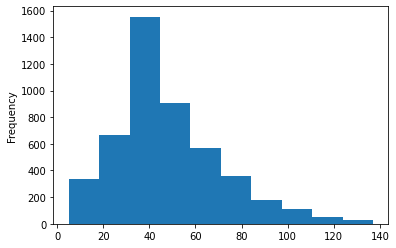

In [17]:
train_df["text"].str.len().plot(kind="hist")

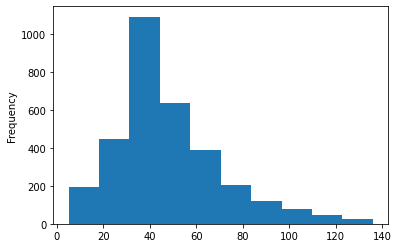

In [18]:
test_df["text"].str.len().plot(kind="hist")

trainとtestで違いはなく、だいたい140文字以内に収まっているようです

In [19]:
eda_df = train_df.copy()

In [20]:
eda_df['length'] = eda_df['text'].apply(lambda x:len(x))
eda_df.head()

,id,source,text,label,length
2,c535f5613,livejupiter,日本人として生まれても無能な低学歴って分かったら日本人の権利剥奪して追放すべきやろ\n甘えるな,1,46
34,69d0d4458,livejupiter,そら女には力はないし頭も男の方が優れてるからな\n女には女の仕事があって、男には男の仕事がある\n\n男に満足な育児はできへんからなその点で男は女に劣ってる,1,75
46,252ac74ca,newsplus,北朝鮮による日本人拉致と平行して、在日朝鮮人の拉致も行われている。\n日本から在日朝鮮人を拉致して工作員として訓練後、再び日本へ密入国させた事件はあるよ。\n韓国政府も新潟日赤センタービルを爆破させようと工作員を密入国させたから、朝鮮人は等しく入国禁止が必要。,1,128
57,604fad2a9,news4vip,独身女なんて人間としての価値無いからな\n女の仕事は、養鶏場の鶏と同じで、産むのが仕事\nその仕事を放棄しているのならば、産まなくなった鶏と同じように廃棄すれば良い,1,80
94,4b6452c69,livejupiter,日本人じゃないしいいよ別に\n偽善大国日本なんて滅んだらいい,1,29


In [21]:
import seaborn as sns

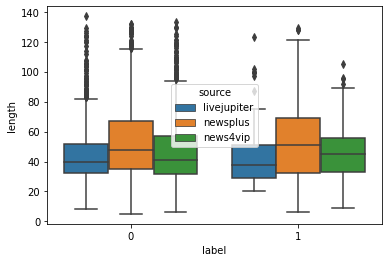

In [22]:
sns.boxplot(data = eda_df, x = 'label', y = 'length', hue = 'source')

In [23]:
rem_symbol_list = [
    '!',
    '"',
    '#',
    '$',
    '%',
    '&',
    '(',
    ')',
    '-',
    '=',
    '^',
    '~',
    '|',
    '@',
    '[',
    '{',
    '`',
    ';',
    '+',
    ':',
    '*',
    ']',
    '}',
    ',',
    '<',
    '.',
    '>',
    '/',
    '?',
    '_',
    '「',
    '」',
    '。',
    '、',
    '･',
    '∀',
    'Дﾟ',
    '￣'
    '＼',
    'Σ',
    '∧',
    '°',
    'ω',
    '∴',
    '￣',
    'ヮﾟ',
    'ﾉ',
    '´',
    '꒳',
    '｢',
    '｣'
]

In [24]:
import urllib.request
slothlib_path = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
slothlib_file = urllib.request.urlopen(slothlib_path)
slothlib_stopwords = [line.decode("utf-8").strip() for line in slothlib_file]
slothlib_stopwords = [ss for ss in slothlib_stopwords if not ss==u'']

In [25]:
rem_stopwords_list = rem_symbol_list + slothlib_stopwords

rem_num_list = [chr(i) for i in range(48, 48+10)]
rem_num_list += [chr(i) for i in range(65296, 65296+10)]

rem_moji_list = [chr(i) for i in range(12353, 12436)]
rem_moji_list += [chr(i) for i in range(12449, 12532+1)]
rem_moji_list += [chr(i) for i in range(97, 97+26)]
rem_moji_list += [chr(i) for i in range(65, 65+26)]

rem_dob_symbol_list = [str(ii) + str(jj) for ii in rem_symbol_list for jj in rem_symbol_list]

rem_word_list = rem_symbol_list + rem_dob_symbol_list + rem_num_list + rem_moji_list

# !pip install urllib
import urllib.request
slothlib_path = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
slothlib_file = urllib.request.urlopen(slothlib_path)
slothlib_stopwords = [line.decode("utf-8").strip() for line in slothlib_file]
slothlib_stopwords = [ss for ss in slothlib_stopwords if not ss==u'']

In [26]:
rem_stopwords_list = rem_stopwords_list[:151]

rem_stopwords_list = rem_word_list + slothlib_stopwords


# 前処理

In [27]:
def preprocessing(df):

    preprocessed_df = df.copy()
    preprocessed_df['text'] = preprocessed_df['text'].apply(lambda x:x.replace('\n', ''))
    preprocessed_df['text'] = preprocessed_df['text'].apply(lambda x:x.replace(' ', ''))
    preprocessed_df['text'] = preprocessed_df['text'].apply(lambda x:x.replace('　', ''))
    preprocessed_df['text'] = preprocessed_df['text'].apply(lambda x:neologdn.normalize(x, repeat=3))
    preprocessed_df['text'] = preprocessed_df['text'].apply(mojimoji.zen_to_han)

    for rem_stopwords in rem_stopwords_list:
        preprocessed_df['text'] = preprocessed_df['text'].apply(lambda x:x.replace(rem_stopwords, ''))
    display(preprocessed_df.head())

    return preprocessed_df

In [28]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

,id,source,text,label
2,c535f5613,livejupiter,日本人として生まれても無能な低学歴って分かったら日本人の権利剥奪して追放すべきやろ甘えるな,1
34,69d0d4458,livejupiter,そら女には力はないし頭も男の方が優れてるな女には女の仕事があって､男には男の仕事がある男に満足な育児はできなその点で男は女に劣ってる,1
46,252ac74ca,newsplus,北朝鮮による日本人拉致と平行して､在日朝鮮人の拉致も行われている｡日本在日朝鮮人を拉致して工作員として訓練後､再び日本へ密入国させた事件はあるよ｡韓国政府も新潟日赤ｾﾝﾀｰﾋﾞﾙを爆破させと工作員を密入国させた､朝鮮人は等しく入国禁止が必要｡,1
57,604fad2a9,news4vip,独身女て人間としての価値無いな女の仕事は､養鶏場の鶏と同じで､産むのが仕事その仕事を放棄しているのならば､産まなくなった鶏と同じに廃棄すれば良い,1
94,4b6452c69,livejupiter,日本人じゃないしいいよ別に偽善大国日本て滅んだらいい,1


,id,source,text
0,001026808,news4vip,上でも言ったけどｵﾀｸﾚﾍﾞﾙの知識求めてる訳じゃないただ囲碁やりますって人が誰1人ﾌﾟﾛ棋士わかりません､布石も知りませんなら申し訳ないけどお祈りかな
1,00465ac96,livejupiter,たとえば､黒人かは､生物学的欠陥はないのに､文化的要因で､悪循環に陥り､実力をつけられずに生きてきて､に差別されていた
2,004674725,livejupiter,やろなあ色々と勿体ない感じしたわ終わり方と黒幕ｷｬﾗは好きやったでちなﾜｲはﾀﾞｰｸﾅｲﾄよりﾊﾞｯﾄﾞﾏﾝﾘﾀｰﾝｽﾞが好きやで
3,00474460f,news4vip,法的というか自治体にﾊﾞﾗﾊﾞﾗの条例で定めてるだけだな普通の淫行条例だと青少年に淫らな性交をしてはならんになってるは淫らの定義の問題だ｡ちなみに東京都では婚約中やに等しい真摯な交際と認められる場合は含まない
4,004a7525c,newsplus,別のｼﾞｬｰﾅﾘｽﾄの感想として言われてるので客観的な事実とは言えないけど､現地は不測の事態が起こるので1週間でこのｽｹｼﾞｭｰﾙはない､とか言ってた｡


In [29]:
train_df['text'].head(100)

2                                                                                   日本人として生まれても無能な低学歴って分かったら日本人の権利剥奪して追放すべきやろ甘えるな
34                                                             そら女には力はないし頭も男の方が優れてるな女には女の仕事があって､男には男の仕事がある男に満足な育児はできなその点で男は女に劣ってる
46      北朝鮮による日本人拉致と平行して､在日朝鮮人の拉致も行われている｡日本在日朝鮮人を拉致して工作員として訓練後､再び日本へ密入国させた事件はあるよ｡韓国政府も新潟日赤ｾﾝﾀｰﾋﾞﾙを爆破させと工作員を密入国させた､朝鮮人は等しく入国禁止が必要｡
57                                                       独身女て人間としての価値無いな女の仕事は､養鶏場の鶏と同じで､産むのが仕事その仕事を放棄しているのならば､産まなくなった鶏と同じに廃棄すれば良い
94                                                                                                     日本人じゃないしいいよ別に偽善大国日本て滅んだらいい
115                                                                                                                    在日朝鮮人は悪魔だな
120                                                                                                        何語かも解んわ死ねよｳﾝｺ在日ｱｲﾇめ殺すぞ
156                                                                 人類は皆平等だ但しｸｿｷﾘｽﾄ教徒やﾑｽﾘﾑ

# validationの作成
train_test_splitでvalidationセットを作成します

In [30]:
from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
x = train_df['text'].values
y = train_df['label'].values

In [31]:
class HateSpeechDataset(Dataset):
  def __init__(self, X, y=None):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    input = {
        "input_ids": self.X[index]["input_ids"],
        "attention_mask": self.X[index]["attention_mask"],
    }
    
    if self.y is not None:
      input["label"] = self.y[index]

    return input

In [32]:
# trainerの訓練中に評価関数を追跡できるように関数を作成しておきます
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    result = f1_score(p.label_ids, preds)
    return {"f1_score":result}

In [33]:
sub_list = []


for random_value in [0, 1, 42]:

    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_value)

    for train_index, val_index in skf.split(x, y):
        fold_train_x = x[train_index]
        fold_train_y = y[train_index]
        fold_val_x = x[val_index]
        fold_val_y = y[val_index]

        cfg = {
            "model_name":"cl-tohoku/bert-base-japanese-whole-word-masking",
            "max_length":-1,
            "train_epoch":3,
            "lr":3e-5,
        }

        # トークナイザとモデルの用意
        tokenizer = AutoTokenizer.from_pretrained(cfg["model_name"])
        model = AutoModelForSequenceClassification.from_pretrained(cfg["model_name"])

        cfg["max_length"]=77

        trn_X = [tokenizer(text, padding="max_length", max_length=cfg["max_length"], truncation=True) for text in tqdm(fold_train_x)]
        trn_ds = HateSpeechDataset(trn_X, fold_train_y)

        val_X = [tokenizer(text, padding="max_length", max_length=cfg["max_length"], truncation=True) for text in tqdm(fold_val_x)]
        val_ds = HateSpeechDataset(val_X, fold_val_y)

        test_X = [tokenizer(text, padding="max_length", max_length=cfg["max_length"], truncation=True) for text in tqdm(test_df["text"])]
        test_ds = HateSpeechDataset(test_X)

        tokenizer.decode(trn_ds[0]["input_ids"])

        trainer_args = TrainingArguments(
            seed=SEED,
            output_dir=".",
            overwrite_output_dir=True,
            do_train=True,
            do_eval=True,
            evaluation_strategy="epoch",
            logging_strategy="epoch",
            save_steps=1e6, # saveのステップを大きくしてここではモデルの保存を行わないようにする
            log_level="critical",
            num_train_epochs=cfg["train_epoch"],
            learning_rate=cfg["lr"],
            per_device_train_batch_size=8,
            per_device_eval_batch_size=12,
            save_total_limit=1,
            fp16=True,
            remove_unused_columns=False,
            report_to="none"
        )

        trainer = Trainer(
            model=model,
            args=trainer_args,
            tokenizer=tokenizer,
            train_dataset=trn_ds,
            eval_dataset=val_ds,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        test_preds = trainer.predict(test_ds)
        test_preds_max = np.argmax(test_preds.predictions, axis=1)
        sub_list.append(test_preds_max)

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

  0%|          | 0/3808 [00:00<?, ?it/s]

  0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1 Score
1,0.215200,0.212217,0.345679
2,0.108100,0.208794,0.528302
3,0.030600,0.299967,0.593750


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2218, 'learning_rate': 2.0041928721174004e-05, 'epoch': 1.0}
{'eval_loss': 0.15222853422164917, 'eval_f1_score': 0.1515151515151515, 'eval_runtime': 1.7589, 'eval_samples_per_second': 541.239, 'eval_steps_per_second': 45.482, 'epoch': 1.0}
{'loss': 0.1048, 'learning_rate': 1.0041928721174005e-05, 'epoch': 2.0}
{'eval_loss': 0.17756378650665283, 'eval_f1_score': 0.6476190476190475, 'eval_runtime': 1.7465, 'eval_samples_per_second': 545.101, 'eval_steps_per_second': 45.807, 'epoch': 2.0}
{'loss': 0.0302, 'learning_rate': 6.289308176100629e-08, 'epoch': 3.0}
{'eval_loss': 0.23919853568077087, 'eval_f1_score': 0.5892857142857144, 'eval_runtime': 1.7569, 'eval_samples_per_second': 541.863, 'eval_steps_per_second': 45.535, 'epoch': 3.0}
{'train_runtime': 143.3261, 'train_samples_per_second': 79.727, 'train_steps_per_second': 9.984, 'train_loss': 0.11895152291245265, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2358, 'learning_rate': 2.0062893081761005e-05, 'epoch': 1.0}
{'eval_loss': 0.15865184366703033, 'eval_f1_score': 0.4403669724770642, 'eval_runtime': 1.7503, 'eval_samples_per_second': 543.908, 'eval_steps_per_second': 45.707, 'epoch': 1.0}
{'loss': 0.1497, 'learning_rate': 1.0062893081761008e-05, 'epoch': 2.0}
{'eval_loss': 0.19382204115390778, 'eval_f1_score': 0.5873015873015873, 'eval_runtime': 1.7424, 'eval_samples_per_second': 546.36, 'eval_steps_per_second': 45.913, 'epoch': 2.0}
{'loss': 0.0667, 'learning_rate': 6.289308176100629e-08, 'epoch': 3.0}
{'eval_loss': 0.2462906390428543, 'eval_f1_score': 0.6290322580645161, 'eval_runtime': 1.7608, 'eval_samples_per_second': 540.657, 'eval_steps_per_second': 45.433, 'epoch': 3.0}
{'train_runtime': 143.2112, 'train_samples_per_second': 79.791, 'train_steps_per_second': 9.992, 'train_loss': 0.15075011956450157, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.212, 'learning_rate': 2.0020964360587003e-05, 'epoch': 1.0}
{'eval_loss': 0.15961189568042755, 'eval_f1_score': 0.22222222222222224, 'eval_runtime': 1.7495, 'eval_samples_per_second': 544.144, 'eval_steps_per_second': 45.726, 'epoch': 1.0}
{'loss': 0.1046, 'learning_rate': 1.0041928721174005e-05, 'epoch': 2.0}
{'eval_loss': 0.18402798473834991, 'eval_f1_score': 0.544, 'eval_runtime': 1.7474, 'eval_samples_per_second': 544.799, 'eval_steps_per_second': 45.781, 'epoch': 2.0}
{'loss': 0.0277, 'learning_rate': 6.289308176100629e-08, 'epoch': 3.0}
{'eval_loss': 0.2529660165309906, 'eval_f1_score': 0.5399999999999999, 'eval_runtime': 1.7336, 'eval_samples_per_second': 549.143, 'eval_steps_per_second': 46.146, 'epoch': 3.0}
{'train_runtime': 142.46, 'train_samples_per_second': 80.212, 'train_steps_per_second': 10.045, 'train_loss': 0.11476062345471438, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2156, 'learning_rate': 2.0020964360587003e-05, 'epoch': 1.0}
{'eval_loss': 0.16998453438282013, 'eval_f1_score': 0.0, 'eval_runtime': 1.7436, 'eval_samples_per_second': 545.998, 'eval_steps_per_second': 45.882, 'epoch': 1.0}
{'loss': 0.0916, 'learning_rate': 1.0041928721174005e-05, 'epoch': 2.0}
{'eval_loss': 0.22162453830242157, 'eval_f1_score': 0.4337349397590361, 'eval_runtime': 1.7344, 'eval_samples_per_second': 548.883, 'eval_steps_per_second': 46.125, 'epoch': 2.0}
{'loss': 0.0357, 'learning_rate': 4.192872117400419e-08, 'epoch': 3.0}
{'eval_loss': 0.22412580251693726, 'eval_f1_score': 0.6355140186915887, 'eval_runtime': 1.7419, 'eval_samples_per_second': 546.524, 'eval_steps_per_second': 45.926, 'epoch': 3.0}
{'train_runtime': 142.2932, 'train_samples_per_second': 80.306, 'train_steps_per_second': 10.057, 'train_loss': 0.11426648153948833, 'epoch': 3.0}


  0%|          | 0/3808 [00:00<?, ?it/s]

  0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2066, 'learning_rate': 2.004201680672269e-05, 'epoch': 1.0}
{'eval_loss': 0.16245298087596893, 'eval_f1_score': 0.0, 'eval_runtime': 1.7532, 'eval_samples_per_second': 543.571, 'eval_steps_per_second': 45.63, 'epoch': 1.0}
{'loss': 0.1102, 'learning_rate': 1.0042016806722688e-05, 'epoch': 2.0}
{'eval_loss': 0.20104221999645233, 'eval_f1_score': 0.6507936507936509, 'eval_runtime': 1.7412, 'eval_samples_per_second': 547.332, 'eval_steps_per_second': 45.946, 'epoch': 2.0}
{'loss': 0.0333, 'learning_rate': 4.2016806722689076e-08, 'epoch': 3.0}
{'eval_loss': 0.24604396522045135, 'eval_f1_score': 0.6260869565217392, 'eval_runtime': 1.7571, 'eval_samples_per_second': 542.38, 'eval_steps_per_second': 45.53, 'epoch': 3.0}
{'train_runtime': 141.7528, 'train_samples_per_second': 80.591, 'train_steps_per_second': 10.074, 'train_loss': 0.11673333264198624, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2317, 'learning_rate': 2.0020964360587003e-05, 'epoch': 1.0}
{'eval_loss': 0.1772213578224182, 'eval_f1_score': 0.5652173913043477, 'eval_runtime': 1.7461, 'eval_samples_per_second': 545.212, 'eval_steps_per_second': 45.816, 'epoch': 1.0}
{'loss': 0.1297, 'learning_rate': 1.0041928721174005e-05, 'epoch': 2.0}
{'eval_loss': 0.1621532440185547, 'eval_f1_score': 0.591304347826087, 'eval_runtime': 1.7338, 'eval_samples_per_second': 549.09, 'eval_steps_per_second': 46.142, 'epoch': 2.0}
{'loss': 0.0455, 'learning_rate': 6.289308176100629e-08, 'epoch': 3.0}
{'eval_loss': 0.234699547290802, 'eval_f1_score': 0.6126126126126127, 'eval_runtime': 1.7373, 'eval_samples_per_second': 547.985, 'eval_steps_per_second': 46.049, 'epoch': 3.0}
{'train_runtime': 142.0361, 'train_samples_per_second': 80.451, 'train_steps_per_second': 10.075, 'train_loss': 0.13561405392479514, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2079, 'learning_rate': 2.0020964360587003e-05, 'epoch': 1.0}
{'eval_loss': 0.23176075518131256, 'eval_f1_score': 0.40476190476190477, 'eval_runtime': 1.7413, 'eval_samples_per_second': 546.723, 'eval_steps_per_second': 45.943, 'epoch': 1.0}
{'loss': 0.0928, 'learning_rate': 1.0041928721174005e-05, 'epoch': 2.0}
{'eval_loss': 0.25374123454093933, 'eval_f1_score': 0.5504587155963302, 'eval_runtime': 1.7289, 'eval_samples_per_second': 550.65, 'eval_steps_per_second': 46.273, 'epoch': 2.0}
{'loss': 0.034, 'learning_rate': 4.192872117400419e-08, 'epoch': 3.0}
{'eval_loss': 0.25940605998039246, 'eval_f1_score': 0.5789473684210527, 'eval_runtime': 1.7288, 'eval_samples_per_second': 550.675, 'eval_steps_per_second': 46.275, 'epoch': 3.0}
{'train_runtime': 141.0474, 'train_samples_per_second': 81.015, 'train_steps_per_second': 10.146, 'train_loss': 0.11155884354202836, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2229, 'learning_rate': 2.0020964360587003e-05, 'epoch': 1.0}
{'eval_loss': 0.20290715992450714, 'eval_f1_score': 0.14705882352941174, 'eval_runtime': 1.7419, 'eval_samples_per_second': 546.532, 'eval_steps_per_second': 45.927, 'epoch': 1.0}
{'loss': 0.1111, 'learning_rate': 1.0020964360587002e-05, 'epoch': 2.0}
{'eval_loss': 0.1817370057106018, 'eval_f1_score': 0.5333333333333333, 'eval_runtime': 1.738, 'eval_samples_per_second': 547.766, 'eval_steps_per_second': 46.031, 'epoch': 2.0}
{'loss': 0.0371, 'learning_rate': 2.0964360587002095e-08, 'epoch': 3.0}
{'eval_loss': 0.23540948331356049, 'eval_f1_score': 0.5619834710743801, 'eval_runtime': 1.7391, 'eval_samples_per_second': 547.404, 'eval_steps_per_second': 46.0, 'epoch': 3.0}
{'train_runtime': 141.0735, 'train_samples_per_second': 81.0, 'train_steps_per_second': 10.144, 'train_loss': 0.12369749547717124, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2196, 'learning_rate': 2.0041928721174004e-05, 'epoch': 1.0}
{'eval_loss': 0.16826952993869781, 'eval_f1_score': 0.5932203389830507, 'eval_runtime': 1.7363, 'eval_samples_per_second': 548.289, 'eval_steps_per_second': 46.075, 'epoch': 1.0}
{'loss': 0.1123, 'learning_rate': 1.0041928721174005e-05, 'epoch': 2.0}
{'eval_loss': 0.19278061389923096, 'eval_f1_score': 0.6446280991735538, 'eval_runtime': 1.7349, 'eval_samples_per_second': 548.741, 'eval_steps_per_second': 46.113, 'epoch': 2.0}
{'loss': 0.0357, 'learning_rate': 6.289308176100629e-08, 'epoch': 3.0}
{'eval_loss': 0.23353122174739838, 'eval_f1_score': 0.6363636363636364, 'eval_runtime': 1.7454, 'eval_samples_per_second': 545.427, 'eval_steps_per_second': 45.834, 'epoch': 3.0}
{'train_runtime': 141.6262, 'train_samples_per_second': 80.684, 'train_steps_per_second': 10.104, 'train_loss': 0.12252089062576774, 'epoch': 3.0}


  0%|          | 0/3808 [00:00<?, ?it/s]

  0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2218, 'learning_rate': 2.004201680672269e-05, 'epoch': 1.0}
{'eval_loss': 0.13730159401893616, 'eval_f1_score': 0.3736263736263736, 'eval_runtime': 1.7493, 'eval_samples_per_second': 544.797, 'eval_steps_per_second': 45.733, 'epoch': 1.0}
{'loss': 0.1223, 'learning_rate': 1.0063025210084032e-05, 'epoch': 2.0}
{'eval_loss': 0.19506022334098816, 'eval_f1_score': 0.5999999999999999, 'eval_runtime': 1.7437, 'eval_samples_per_second': 546.541, 'eval_steps_per_second': 45.88, 'epoch': 2.0}
{'loss': 0.0492, 'learning_rate': 6.302521008403361e-08, 'epoch': 3.0}
{'eval_loss': 0.2301686406135559, 'eval_f1_score': 0.6307692307692307, 'eval_runtime': 1.7316, 'eval_samples_per_second': 550.354, 'eval_steps_per_second': 46.2, 'epoch': 3.0}
{'train_runtime': 141.1497, 'train_samples_per_second': 80.935, 'train_steps_per_second': 10.117, 'train_loss': 0.13110079351259546, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2238, 'learning_rate': 2.0020964360587003e-05, 'epoch': 1.0}
{'eval_loss': 0.14521424472332, 'eval_f1_score': 0.4842105263157894, 'eval_runtime': 1.738, 'eval_samples_per_second': 547.767, 'eval_steps_per_second': 46.031, 'epoch': 1.0}
{'loss': 0.1251, 'learning_rate': 1.0041928721174005e-05, 'epoch': 2.0}
{'eval_loss': 0.17587415874004364, 'eval_f1_score': 0.5740740740740742, 'eval_runtime': 1.7329, 'eval_samples_per_second': 549.362, 'eval_steps_per_second': 46.165, 'epoch': 2.0}
{'loss': 0.0409, 'learning_rate': 6.289308176100629e-08, 'epoch': 3.0}
{'eval_loss': 0.24250678718090057, 'eval_f1_score': 0.588235294117647, 'eval_runtime': 1.7496, 'eval_samples_per_second': 544.119, 'eval_steps_per_second': 45.724, 'epoch': 3.0}
{'train_runtime': 141.5555, 'train_samples_per_second': 80.725, 'train_steps_per_second': 10.109, 'train_loss': 0.1299259790917696, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2132, 'learning_rate': 2.0062893081761005e-05, 'epoch': 1.0}
{'eval_loss': 0.16215457022190094, 'eval_f1_score': 0.5977011494252873, 'eval_runtime': 1.7471, 'eval_samples_per_second': 544.893, 'eval_steps_per_second': 45.789, 'epoch': 1.0}
{'loss': 0.1033, 'learning_rate': 1.0062893081761008e-05, 'epoch': 2.0}
{'eval_loss': 0.1904689222574234, 'eval_f1_score': 0.6306306306306306, 'eval_runtime': 1.7407, 'eval_samples_per_second': 546.918, 'eval_steps_per_second': 45.96, 'epoch': 2.0}
{'loss': 0.028, 'learning_rate': 6.289308176100629e-08, 'epoch': 3.0}
{'eval_loss': 0.23025618493556976, 'eval_f1_score': 0.672, 'eval_runtime': 1.7372, 'eval_samples_per_second': 548.023, 'eval_steps_per_second': 46.052, 'epoch': 3.0}
{'train_runtime': 143.4178, 'train_samples_per_second': 79.676, 'train_steps_per_second': 9.978, 'train_loss': 0.11483566849320023, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.22, 'learning_rate': 2.0020964360587003e-05, 'epoch': 1.0}
{'eval_loss': 0.18824154138565063, 'eval_f1_score': 0.20289855072463767, 'eval_runtime': 1.7423, 'eval_samples_per_second': 546.4, 'eval_steps_per_second': 45.916, 'epoch': 1.0}
{'loss': 0.1225, 'learning_rate': 1.0041928721174005e-05, 'epoch': 2.0}
{'eval_loss': 0.2371884137392044, 'eval_f1_score': 0.5208333333333334, 'eval_runtime': 1.7333, 'eval_samples_per_second': 549.256, 'eval_steps_per_second': 46.156, 'epoch': 2.0}
{'loss': 0.041, 'learning_rate': 4.192872117400419e-08, 'epoch': 3.0}
{'eval_loss': 0.2966929078102112, 'eval_f1_score': 0.4999999999999999, 'eval_runtime': 1.7553, 'eval_samples_per_second': 542.363, 'eval_steps_per_second': 45.577, 'epoch': 3.0}
{'train_runtime': 142.6341, 'train_samples_per_second': 80.114, 'train_steps_per_second': 10.033, 'train_loss': 0.12783391220764545, 'epoch': 3.0}


  0%|          | 0/3809 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

  0%|          | 0/3223 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.2205, 'learning_rate': 2.0062893081761005e-05, 'epoch': 1.0}
{'eval_loss': 0.12257672101259232, 'eval_f1_score': 0.40963855421686746, 'eval_runtime': 1.8317, 'eval_samples_per_second': 519.731, 'eval_steps_per_second': 43.675, 'epoch': 1.0}
{'loss': 0.1121, 'learning_rate': 1.0062893081761008e-05, 'epoch': 2.0}
{'eval_loss': 0.16997547447681427, 'eval_f1_score': 0.4050632911392405, 'eval_runtime': 1.738, 'eval_samples_per_second': 547.743, 'eval_steps_per_second': 46.029, 'epoch': 2.0}
{'loss': 0.0259, 'learning_rate': 6.289308176100629e-08, 'epoch': 3.0}
{'eval_loss': 0.2338627725839615, 'eval_f1_score': 0.5393258426966292, 'eval_runtime': 1.7488, 'eval_samples_per_second': 544.377, 'eval_steps_per_second': 45.746, 'epoch': 3.0}
{'train_runtime': 143.4326, 'train_samples_per_second': 79.668, 'train_steps_per_second': 9.977, 'train_loss': 0.11949126125631593, 'epoch': 3.0}


In [34]:
from scipy import stats
tmp = stats.mode(sub_list, axis = 0)

In [35]:
tmp[0][0]

array([0, 1, 0, ..., 0, 0, 0])

trn_df, val_df = train_test_split(train_df, test_size=0.3, stratify=train_df["label"], random_state=SEED)

結果は0.32でした。  
ルールベース以外の手法を使う場合、この精度を超えられるようにモデルの作成を行う必要があります。

# モデル作成
事前学習済みモデルには`cl-tohoku/bert-base-japanese-whole-word-masking`を使用します。

cfg = {
    "model_name":"cl-tohoku/bert-base-japanese-whole-word-masking",
    "max_length":-1,
    "train_epoch":3,
    "lr":3e-5,
}

# トークナイザとモデルの用意
tokenizer = AutoTokenizer.from_pretrained(cfg["model_name"])
model = AutoModelForSequenceClassification.from_pretrained(cfg["model_name"])

# 訓練とテストのデータセットを結合して、トークナイズした際の単語数を調べます
whole_texts = train_df["text"].to_list() + test_df["text"].to_list()
whole_text_lengths = [len(tokenizer.encode(text)) for text in tqdm(whole_texts)]

pd.Series(whole_text_lengths).describe(percentiles=[0.90, 0.95, 0.99])

# 99％は77トークンで収まるので最大トークン数を77に設定しておきます
cfg["max_length"]=77

## Dataset
テキストをトークナイズしてデータセットを作成します

trn_X = [tokenizer(text, padding="max_length", max_length=cfg["max_length"], truncation=True) for text in tqdm(trn_df["text"])]
trn_ds = HateSpeechDataset(trn_X, trn_df["label"].tolist())

val_X = [tokenizer(text, padding="max_length", max_length=cfg["max_length"], truncation=True) for text in tqdm(val_df["text"])]
val_ds = HateSpeechDataset(val_X, val_df["label"].tolist())

test_X = [tokenizer(text, padding="max_length", max_length=cfg["max_length"], truncation=True) for text in tqdm(test_df["text"])]
test_ds = HateSpeechDataset(test_X)

tokenizer.decode(trn_ds[0]["input_ids"])

# トレーニング
ここでは、訓練を簡単に行うために、`Transformers`ライブラリにある`Trainer`モジュールを利用します。

`Trainer`モジュールに使用する引数等の設定は以下のリファレンスをご参考下さい。
- https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer
- https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments

trainer_args = TrainingArguments(
    seed=SEED,
    output_dir=".",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_steps=1e6, # saveのステップを大きくしてここではモデルの保存を行わないようにする
    log_level="critical",
    num_train_epochs=cfg["train_epoch"],
    learning_rate=cfg["lr"],
    per_device_train_batch_size=8,
    per_device_eval_batch_size=12,
    save_total_limit=1,
    fp16=True,
    remove_unused_columns=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=trainer_args,
    tokenizer=tokenizer,
    train_dataset=trn_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

# テストの推論

test_preds = trainer.predict(test_ds)

In [36]:
sub_df["label"] = tmp[0][0]

In [37]:
sub_df["label"].value_counts()

0    3052
1     171
Name: label, dtype: int64

In [38]:
display(sub_df.head())

,id,label
0,001026808,0
1,00465ac96,1
2,004674725,0
3,00474460f,0
4,004a7525c,0


# 保存

In [39]:
COMPETION_OUTPUT_DIR = Path("/content/drive/MyDrive/output/nishika/hate_speech")

sub_df.to_csv(COMPETION_OUTPUT_DIR / "sub.csv", index=False)

In [40]:
display(sub_df.head())

,id,label
0,001026808,0
1,00465ac96,1
2,004674725,0
3,00474460f,0
4,004a7525c,0


チュートリアルを提出するとパブリックリーダーボードで0.53となります  
改善のアイデアには
- `train_test_split`から`StratifiedKFold`にしてみる
- ダウンサンプリングしてデータセットの不均衡を処理する
- 事前学習モデルを変更してみる
- ハイパーパラメーターを調整する
- データソースである[`おーぷん2ちゃんねる対話コーパス`](https://github.com/1never/open2ch-dialogue-corpus)を利用する

などが考えられます。  ぜひ、良いスコアが出るように挑戦してみて下さい